<img src="newlogomioti.png" style="height: 100px">


&nbsp;
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning 2 (Unsupervised learning)</center>

# Challenge S2: Aprendizaje no supervisado: PCA

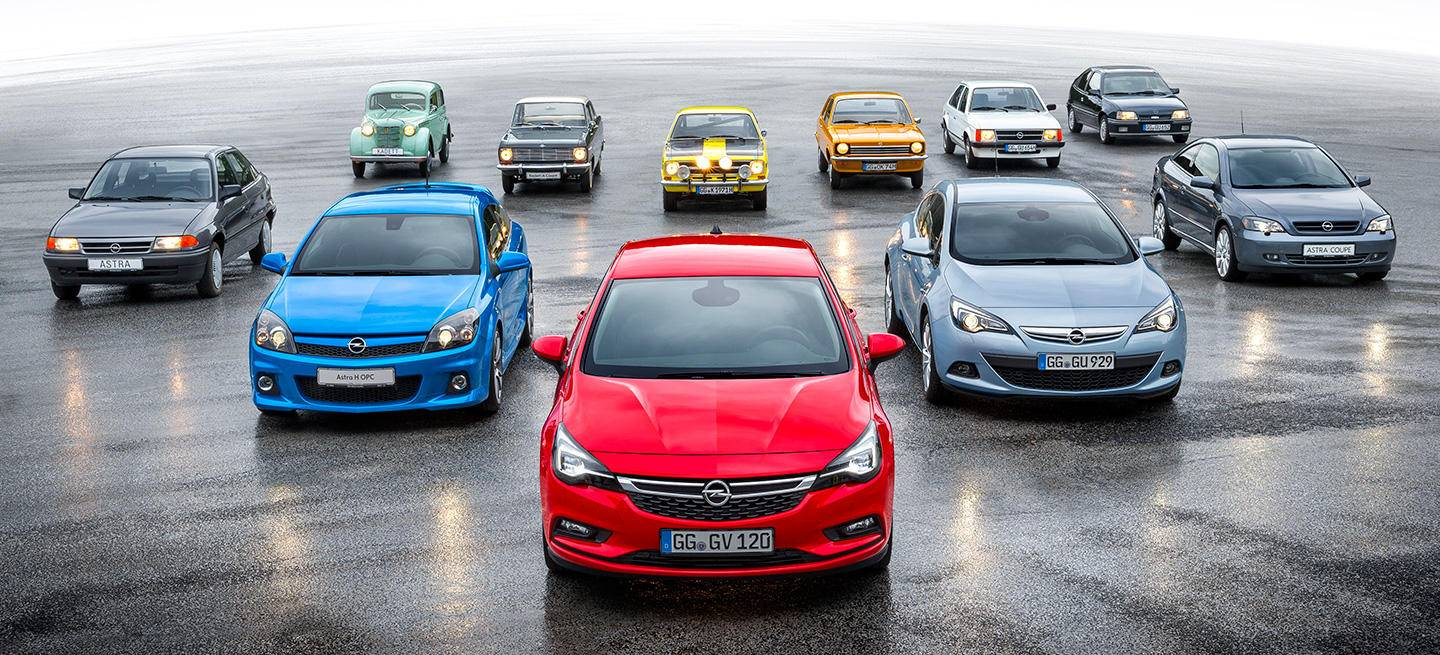

## Objetivos

El objetivo de este challenge es reducir la dimensión de un dataset que dispone de las características de distintos modelos de coches, en especial todoterrenos y turismos.

Para ello, utilizando la técnica de PCA realizaremos una reducción de dimensionalidad de las variables que nos indican las características (tamaño del motor, distancia entre ejes, longitud, anchura, ...) y posteriormente veremos si quedan identificados los todoterrenos y turismos.

### Importando y preparando dataset

In [2]:
#importamos las librerías
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
coche=pd.read_csv('Car_sales.csv')
coche.head()

,Manufacturer,Model,Sales in thousands,4-year resale value,Vehicle type,Price in thousands,Engine size,Horsepower,Wheelbase,Width,Length,Curb weight,Fuel capacity,Fuel efficiency,Latest Launch
0,Acura,Integra,16.919,16.36,Passenger,21.5,1.8,140,101.2,67.3,172.4,2.639,13.2,28,2-Feb-14
1,Acura,TL,39.384,19.875,Passenger,28.4,3.2,225,108.1,70.3,192.9,3.517,17.2,25,6-Mar-15
2,Acura,CL,14.114,18.225,Passenger,.,3.2,225,106.9,70.6,192,3.47,17.2,26,1-Apr-14
3,Acura,RL,8.588,29.725,Passenger,42,3.5,210,114.6,71.4,196.6,3.85,18,22,3-Oct-15
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150,102.6,68.2,178,2.998,16.4,27,10-Aug-15


#### Podemos observar que en este dataset los nombres de las variables vienen con espacios, así como observamos que hay datos que vienen como '.' 

In [4]:
coche = coche.rename(columns={'Sales in thousands':'Sales_in_thousands','4-year resale value':'4_year_resale_value','Vehicle type':'Vehicle_type','Price in thousands':'Price_in_thousands','Engine size':'Engine_size','Curb weight':'Curb_weight','Fuel capacity':'Fuel_capacity','Fuel efficiency':'Fuel_efficiency','Latest Launch':'Latest_Launch'})
coche=coche.replace('.','NaN')

#### Vamos a ver ahora la información del dataset

In [5]:
coche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 15 columns):
Manufacturer           157 non-null object
Model                  157 non-null object
Sales_in_thousands     157 non-null float64
4_year_resale_value    157 non-null object
Vehicle_type           157 non-null object
Price_in_thousands     157 non-null object
Engine_size            157 non-null object
Horsepower             157 non-null object
Wheelbase              157 non-null object
Width                  157 non-null object
Length                 157 non-null object
Curb_weight            157 non-null object
Fuel_capacity          157 non-null object
Fuel_efficiency        157 non-null object
Latest_Launch          157 non-null object
dtypes: float64(1), object(14)
memory usage: 18.5+ KB


#### Observamos que varias de nuestras columnas que deberían ser float son realmente object

In [6]:
coche[['4_year_resale_value','Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency']]=coche[['4_year_resale_value','Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency']].astype(float)

#### Vamos ahora a eliminar los duplicados y comprobar cuantos había

In [7]:
coche = coche.drop_duplicates()
coche.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 156
Data columns (total 15 columns):
Manufacturer           157 non-null object
Model                  157 non-null object
Sales_in_thousands     157 non-null float64
4_year_resale_value    121 non-null float64
Vehicle_type           157 non-null object
Price_in_thousands     155 non-null float64
Engine_size            156 non-null float64
Horsepower             156 non-null float64
Wheelbase              156 non-null float64
Width                  156 non-null float64
Length                 156 non-null float64
Curb_weight            155 non-null float64
Fuel_capacity          156 non-null float64
Fuel_efficiency        154 non-null float64
Latest_Launch          157 non-null object
dtypes: float64(11), object(4)
memory usage: 19.6+ KB


#### En nuestro dataset no había datos duplicados, continuaremos ahora con los missing data

In [8]:
coche.isna().sum()

Manufacturer            0
Model                   0
Sales_in_thousands      0
4_year_resale_value    36
Vehicle_type            0
Price_in_thousands      2
Engine_size             1
Horsepower              1
Wheelbase               1
Width                   1
Length                  1
Curb_weight             2
Fuel_capacity           1
Fuel_efficiency         3
Latest_Launch           0
dtype: int64

#### Observamos que tenemos 36 missing data en 4_year_resale_value,2 en Price_in_thousands y Curb_weight, 3 en Fuel_efficiency y 1 en Engine_size,Horsepower, Wheelbase, Width,Length,y Fuel_capacity.
### Vamos ahora a cambiar los missing data por el valor de la mediana

In [9]:
coche = coche.fillna(coche.median())

Ya estamos casi a punto de aplicar PCA, antes algunas revisiones previas:
- Verificar que la escala de medida de las variables es similar y sino es así aplicar alguna técnica para conseguirlo.
- Revisar la correlación entre las variables y son las que tienen relación las que aportaran una mayor reducción de la dimensión.

#### Vamos a guardar la información de 2 observaciones, una de cada tipo de coche para luego comprobar en que grupo quedarían localizadas (por ejemplo la primera observación y la 84)

#### Ahora sí, vamos a crear el dataset con las variables a las que les vamos a realizar el PCA

In [10]:
cochepca= coche[['4_year_resale_value', 'Price_in_thousands', 'Engine_size', 'Horsepower','Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity','Fuel_efficiency']]

## Comenzamos con el método PCA

### En primer lugar, seleccionando las componentes por el método del codo

La idea es buscar un codo en el gráfico entre las componentes y la varianza explicada, es decir, un punto a partir del cual el incremento de información explicada es casi la misma. El criterio es quedarse con un número de componentes que excluya los asociados a valores pequeños y aproximadamente del mismo tamaño.


In [11]:
#Recuerda si no lo has hecho antes que vamos a tener que normalizar las variables
Coche_normalizado = StandardScaler().fit_transform(cochepca)
Coche_normalizado

array([[-0.08085067, -0.4100527 , -1.21437647, ..., -1.18272557,
        -1.22870019,  0.98226418],
       [ 0.26558806,  0.07507023,  0.13438527, ...,  0.22328529,
        -0.19338056,  0.27268377],
       [ 0.10296391, -0.31872304,  0.13438527, ...,  0.14802047,
        -0.19338056,  0.50921057],
       ...,
       [-0.29571167,  0.1031933 , -0.63633573, ..., -0.18987052,
        -0.01219963,  0.27268377],
       [-0.29571167,  1.27733143, -0.73267585, ...,  0.35780113,
         0.14309832, -0.20036984],
       [-0.29571167,  0.60940854, -0.1546351 , ...,  0.35619975,
         0.81605607,  0.03615696]])

### Aplicamos PCA con 10 componentes inicialmente

y luego seleccionamos las mínimas necesarias. Primero aplicamos PCA:

y a continuación revisamos la varianza explicada, para ello dibujamos una gráfica entre componentes y varianza acumulada

##### ¿Con cuantas componentes superamos el 85%?  ¿ y esas componentes cuánto aportan realmente?

##### Aplicamos el PCA con el número de componentes que nos ha parecido razonable y graficamos si es posible

##### Y como podemos observar hemos podido disminuir las dimensiones de 10 variables inicialmente a solo algunas componentes

####  Para realizar la gráfica y aunque PCA se usa en no supervisada (es decir sin etiquetas), para verlo mejor vamos a dibujar los coches diferenciándolos entre 'Passenger' y 'Car' tal y como vienen en 'Vehicles_types'

### ¿Consigues ver los grupos separados en la gráfica?

## Predeterminando la cantidad de información de las componentes

####  En segundo lugar, seleccionando las componentes que me aportan el 80% de la información

#### ¿Cuantas componentes principales obtenemos en este caso? ¿Cuanta varianza acumulada proporcionan? Grafica los resultados

##### Podemos comprobar que en efecto su porcentaje supera el 80%

#### ¿Es posible con esta gráfica hacer una gran distinción entre car y passenger?

## ¿Distinguimos el grupo de las dos observaciones test?

#### Para ello accedemos a la página de scikit.sklearn para ver como estandariza StandardScaler y nos fijamos que la forma de estandarizar es: 
###### z = (x - u) / s siendo u la media y s la desv.tipica.

#### De esta manera hemos estandarizado los datos al igual que si hubiesen estado en el dataset original

#### Ahora ya le hemos aplicado las PCA a ambas pruebas y proseguimos con la gráfica

#### ¿Podríamos clasificar a nuestras 2 observaciones de test entre los 2 tipos de vehículos?

## ¿Qué relación tienen las componentes con las variables?

#### Utiliza un indicador que nos permita identificar las relaciones entre variables y componentes

#### ¿Puedes visualizar estas relaciones en una gráfica?

#### ¿Qué variables aportan mas a cada componente?

## Como conclusiones y reflexiones:
* ¿Se te ocurren aplicaciones concretas de PCA en tu entorno?
* ¿En qué situaciones deberíamos ser cuidadosos antes de aplicar PCA?